----
<h1>
    <center>
        Spatio-seasonal analysis of air-sea CO2 fluxes in the Southern Ocean
    </center>
</h1>

----





## Software requirements



### Required rackages

Let's import the modules - packages - we will use in this project.

In [1]:
### Graph and map handlers 
%matplotlib inline
%pylab inline

%run /home/ldjeutchouang/CODE/pyscripts/base/softwares/required_packages.py

Populating the interactive namespace from numpy and matplotlib


### Invoke `Dask` by asking processing power from an existing memory

In [2]:
###### Setup the script invoke dask  
from dask_jobqueue import PBSCluster

### Make up the script 
cluster = PBSCluster(cores=24,
                     memory="108GB",
                     queue="smp",
                     resource_spec="select=1:ncpus=24:mem=120GB",
                     walltime="05:00:00",
                     interface="ib0",
                     job_extra=["-P ERTH0834",
                                "-m abe",
                                "-o /mnt/lustre/users/ldjeutchouang/projects/qlogfiles/dask/",
                                "-e /mnt/lustre/users/ldjeutchouang/projects/qlogfiles/dask/"],
                     scheduler_options={"dashboard_address": ":9875"})

print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q smp
#PBS -l select=1:ncpus=24:mem=120GB
#PBS -l walltime=05:00:00
#PBS -P ERTH0834
#PBS -m abe
#PBS -o /mnt/lustre/users/ldjeutchouang/projects/qlogfiles/dask/
#PBS -e /mnt/lustre/users/ldjeutchouang/projects/qlogfiles/dask/

/home/ldjeutchouang/lustre3p/CONDA/envs/active_research/bin/python -m distributed.cli.dask_worker tcp://172.19.3.14:37483 --nthreads 4 --nprocs 6 --memory-limit 16.76GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



In [3]:
###### Setup the dast client for job submission 
from dask.distributed import Client

### Request from cluster the desired number of jobs/nodes
cluster.scale(jobs=8)
print(cluster, end="\n\n")

### Submit the job to the cluster 
client = Client(cluster)

PBSCluster(424077fd, 'tcp://172.19.3.14:37483', workers=0, threads=0, memory=0 B)



In [4]:
client

Client Scheduler: tcp://172.19.3.14:37483 Dashboard: http://172.19.3.14:9875/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
### Setup the progress checking to estimate how fast would be the workers 
from dask.distributed import progress
import time

def slow_increment(x): 
    time.sleep(10)
    return x + 10 

futures = client.map(slow_increment, range(500))
progress(futures)

VBox()

In [6]:
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [7]:
import dask.array as darr
ones = darr.ones(shape)
ones


dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [48]:
# ones.visualize()

### Essential softwares

In [8]:
#@title Define plotting properties 
from string import ascii_lowercase as asci

def number_figures(axes, pos=None, labels=asci, braces=True, **text_kwargs):

    depth = lambda L: isinstance(L, list) and max(map(depth, L)) + 1

    if pos is None:
        pos = [[0.99, 0.93]] * len(axes)
    elif (depth(pos) == 1) & (len(pos) == 2):
        pos = [list(pos)] * len(axes)
    elif (depth(pos) != 2) & (len(pos) != len(axes)):
        raise (Exception, 'check the position is the right format')
    
    for c, ax in enumerate(axes):
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()

        w = x1 - x0
        h = y1 - y0
        x = x0 + w * pos[c][0]
        y = y0 + h * pos[c][1]

        t = '%s' % labels[c]
        if braces:
            t = '(%s)' % (t)
        ax.text(x, y, t, **text_kwargs)
        
def map_prop(ax, color="#d8dcd6"): 
    ax.grid(zorder=0)
    ax.add_feature(feature.LAND, color="#7d7f7c", zorder=10)
    ax.coastlines(zorder=11)
    ax.gridlines(linestyle="--", linewidth=0.5, alpha=0.5, zorder=11, color=color)
    
def map_prop2(ax, color="#03012d"): 
    ax.grid(zorder=0)
    ax.add_feature(feature.LAND, color="#7d7f7c", zorder=10)
    ax.coastlines(zorder=11)
    ax.gridlines(linestyle="--", linewidth=0.5, alpha=0.5, zorder=11, color=color)

## Data preprocessing

### Requirements

In [9]:
### BIOPERIANT12
sys.path.append("/home/ldjeutchouang/CODE/postPhDs")
from BP12Scripts import bioperiant12 as sbp12

### Data loading

Get the 20 years of CO$_2$ flux data from 1991-2010

In [10]:
suffix_endwith = "diadT.nc"
year_start = 1991
year_end = 2010
time_step = "5-daily"

bp12_diadT = sbp12.BP12DataLoader(suffix_endwith=suffix_endwith,
                                  year_start=year_start,
                                  year_end=year_end,
                                  time_step=time_step)

diadT = bp12_diadT.load()

INFO:root: BIOPERIANT12 data loader instantiation
INFO:root: Load all the datasets at once
INFO:root: Find the file names to be read from the input directory

INFO:root: 1450 files found and 10 file(s) missing!
INFO:root: Making the time axis corresponding to the provided date range



 /1993/BIOPERIANT12-CNCLNG01_y1993m08d23_diadT.nc
 /1994/BIOPERIANT12-CNCLNG01_y1994m06d09_diadT.nc
 /1997/BIOPERIANT12-CNCLNG01_y1997m02d04_diadT.nc
 /1998/BIOPERIANT12-CNCLNG01_y1998m02d24_diadT.nc
 /1998/BIOPERIANT12-CNCLNG01_y1998m09d22_diadT.nc
 /2001/BIOPERIANT12-CNCLNG01_y2001m06d04_diadT.nc
 /2003/BIOPERIANT12-CNCLNG01_y2003m12d01_diadT.nc
 /2007/BIOPERIANT12-CNCLNG01_y2007m02d14_diadT.nc
 /2009/BIOPERIANT12-CNCLNG01_y2009m06d14_diadT.nc
 /2010/BIOPERIANT12-CNCLNG01_y2010m04d05_diadT.nc


In [11]:
bp12_diadT

<BP12DataLoader for 5-daily outputs from 1991 to 2010>

In [12]:
diadT[0]

,Array,Chunk
Bytes,26.19 GiB,1.91 MiB
Shape,"(1450, 1122, 4322)","(1, 500, 1000)"
Count,66700 Tasks,21750 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,26.19 GiB,1.91 MiB
Shape,"(1450, 1122, 4322)","(1, 500, 1000)"
Count,66700 Tasks,21750 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [13]:
diadT[1]

['/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12-CNCLNG01-S/1993/BIOPERIANT12-CNCLNG01_y1993m08d23_diadT.nc',
 '/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12-CNCLNG01-S/1994/BIOPERIANT12-CNCLNG01_y1994m06d09_diadT.nc',
 '/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12-CNCLNG01-S/1997/BIOPERIANT12-CNCLNG01_y1997m02d04_diadT.nc',
 '/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12-CNCLNG01-S/1998/BIOPERIANT12-CNCLNG01_y1998m02d24_diadT.nc',
 '/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12-CNCLNG01-S/1998/BIOPERIANT12-CNCLNG01_y1998m09d22_diadT.nc',
 '/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12-CNCLNG01-S/2001/BIOPERIANT12-CNCLNG01_y2001m06d04_diadT.nc',
 '/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12-CNCLNG01-S/2003/BIOPERIANT12-CNCLNG01_y2003m12d01_diadT.nc',
 '/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12-CNCLNG01-S/2007/BIOPERIANT12-CNCLNG01_y2007m02d14_diadT.nc',
 '/mnt/nrestore/users/ERTH0834/BIOPERIANT12/BIOPERIANT12

In [14]:
diadT[-1][:11]

[Timestamp('1991-01-05 12:00:00'),
 Timestamp('1991-01-10 12:00:00'),
 Timestamp('1991-01-15 12:00:00'),
 Timestamp('1991-01-20 12:00:00'),
 Timestamp('1991-01-25 12:00:00'),
 Timestamp('1991-01-30 12:00:00'),
 Timestamp('1991-02-04 12:00:00'),
 Timestamp('1991-02-09 12:00:00'),
 Timestamp('1991-02-14 12:00:00'),
 Timestamp('1991-02-19 12:00:00'),
 Timestamp('1991-02-24 12:00:00')]

In [15]:
os.chdir("/mnt/lustre/users/ldjeutchouang/projects/PhD/SIME-v2/") 

In [16]:
filename = "./data-out/bp12_nUSV_locs_fts.nc"
xds_bp12_fts = xr.open_dataset(filename, chunks={"lon": 1000})
xds_bp12_fts

<xarray.Dataset>
Dimensions:  (lon: 4320)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.8 179.9 180.0
Data variables:
    lat_stf  (lon) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat_saf  (lon) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat_pf   (lon) float64 dask.array<chunksize=(1000,), meta=np.ndarray>

In [15]:
# dfs = xds_bp12_fts.to_dask_dataframe()
# dfs.head()

### Preprocessing

In [17]:
### Get the path to ocean mask of BIOPERIANT12 ocean model
bp12_mask_path = "/mnt/lustre/users/ldjeutchouang/projects/BP12/bp12_ocean_mask.nc"

bp12_processor = sbp12.BP12DataProcessor(bp12_ocean_mask_path=bp12_mask_path)

INFO:root: BIOPERIANT12 data processor instantiation


In [18]:
bp12_processor

<BP12DataProcessor using the ocean mask @
 /mnt/lustre/users/ldjeutchouang/projects/BP12/bp12_ocean_mask.nc>

In [19]:
### Processing 
var_names = ["Cflx", "Delc"]
xds_diadT = bp12_processor.process(xds_params=diadT,
                                   var_names=var_names)

INFO:root: Data processing
INFO:root: Rescale the data of the variables of interest:



 Cflx:  Coef = 1000000.0, Cmin = -0.4, Cmax = 0.4, and Cstep = 0.01
 Delc:  Coef = 1.0, Cmin = -100.0, Cmax = 100.0, and Cstep = 5.0


In [20]:
xds_diadT

<xarray.Dataset>
Dimensions:  (lat: 1122, lon: 4320, time: 1450)
Coordinates:
  * time     (time) datetime64[ns] 1991-01-05T12:00:00 ... 2010-12-31T12:00:00
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float32 -77.01 -76.99 -76.97 -76.95 ... -29.81 -29.73 -29.66
Data variables:
    Cflx     (time, lat, lon) float32 dask.array<chunksize=(100, 500, 1000), meta=np.ndarray>
    Delc     (time, lat, lon) float32 dask.array<chunksize=(100, 500, 1000), meta=np.ndarray>
Attributes:
    Conventions:       GDT 1.3
    production:        NEMO
    output_frequency:  5d
    CONFIG:            BIOPERIANT12
    CASE:              CNCLNG01

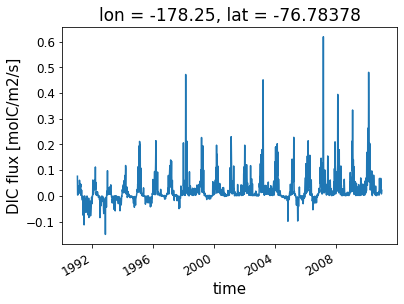

In [27]:
xds_diadT.Cflx[:,12,20].plot()

In [28]:
xds_diadT.Cflx

<xarray.DataArray 'Cflx' (time: 1450, lat: 1122, lon: 4320)>
dask.array<rechunk-merge, shape=(1450, 1122, 4320), dtype=float32, chunksize=(100, 500, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-05T12:00:00 ... 2010-12-31T12:00:00
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float32 -77.01 -76.99 -76.97 -76.95 ... -29.81 -29.73 -29.66
Attributes:
    units:               molC/m2/s
    valid_min:           0.0
    valid_max:           20.0
    long_name:           DIC flux
    short_name:          Cflx
    online_operation:    N/A
    axis:                TYX
    interval_operation:  432000.0
    interval_write:      432000.0
    associate:           time_counter nav_lat nav_lon

## Annual mean and trends

In [29]:
def regional_partition(xds_raw, xds_fronts):
    ### Convert xr.Datasets() to pd.DataFrames()
    xdf_raw = xds_raw.to_dataframe().reset_index()
    xdf_frts = xds_fronts.to_dataframe().reset_index()
    
    ### Split the SCR across the SAZ and the Sub-polar 
    frts_coords = zip(xdf_frts.lat_stf,
                      xdf_frts.lat_saf,
                      xdf_frts.lat_pf,
                      xdf_frts.lon)
    SO = []
    for istf, isaf, ipf, ilon in frts_coords:
        saz_mask = (((xds_raw.lat<=istf) & (xds_raw.lat>=isaf)) & (xds_raw.lon==ilon))
        pfz_mask = (((xds_raw.lat<=isaf) & (xds_raw.lat>=ipf)) & (xds_raw.lon==ilon))
        az_mask = ((xds_raw.lat<=ipf) & (xds_raw.lon==ilon))
        
    return saz_mask, pfz_mask, az_mask

In [31]:
def xarray_trend(xdarr):
    """
    Calculates the trend of the data along the 'time' dimension
    of the input array (xarr).
    USAGE:  x_DS = xarray_trend(xarr)
    INPUT:  xarr is an xarray DataArray with dims:
                time, [lat, lon]
                where lat and/or lon are optional
    OUTPUT: xArray Dataset with:
                original xarr input
                slope
                p-value

    TODO?
    There could be speed improvements (using numpy at the moment)
    """

    from scipy import stats
    # getting shapes

    n = xdarr.shape[0]

    # creating x and y variables for linear regression
    x = xdarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xdarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    # intercept = ym - (slope * xm)
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xdarr.to_dataset(name='placeholder')
    # first create variable for slope and adjust meta
    out['slope'] = xdarr[:2].mean('time').copy()
    out['slope'].name += '_slope'
    out['slope'].attrs['units'] = 'units / day'
    out['slope'].values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    out['pval'] = xdarr[:2].mean('time').copy()
    out['pval'].name += '_Pvalue'
    out['pval'].values = p.reshape(xarr.shape[1:])
    out['pval'].attrs['info'] = ("If p < 0.05 then the results "
                                 "from 'slope' are significant.")


In [30]:
xda = xds_diadT.Cflx.copy()
xda

<xarray.DataArray 'Cflx' (time: 1450, lat: 1122, lon: 4320)>
dask.array<rechunk-merge, shape=(1450, 1122, 4320), dtype=float32, chunksize=(100, 500, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-05T12:00:00 ... 2010-12-31T12:00:00
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float32 -77.01 -76.99 -76.97 -76.95 ... -29.81 -29.73 -29.66
Attributes:
    units:               molC/m2/s
    valid_min:           0.0
    valid_max:           20.0
    long_name:           DIC flux
    short_name:          Cflx
    online_operation:    N/A
    axis:                TYX
    interval_operation:  432000.0
    interval_write:      432000.0
    associate:           time_counter nav_lat nav_lon

In [30]:
diadT[0][["nav_lat", "nav_lon"]]

,Array,Chunk
Bytes,26.19 GiB,1.91 MiB
Shape,"(1450, 1122, 4322)","(1, 500, 1000)"
Count,66700 Tasks,21750 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,26.19 GiB,1.91 MiB
Shape,"(1450, 1122, 4322)","(1, 500, 1000)"
Count,66700 Tasks,21750 Chunks
Type,float32,numpy.ndarray


In [31]:
# xda.set_index(index=("lat", "lon"))

In [ ]:
xds_diadT.reset_coords()

In [37]:
xds_bp12_fts

<xarray.Dataset>
Dimensions:  (lon: 4320)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.8 179.9 180.0
Data variables:
    lat_stf  (lon) float64 -43.77 -43.76 -43.76 -43.76 ... -43.76 -43.77 -43.77
    lat_saf  (lon) float64 -57.07 -57.06 -57.05 -57.05 ... -57.1 -57.09 -57.08
    lat_pf   (lon) float64 -62.05 -62.04 -62.04 -62.03 ... -62.05 -62.05 -62.05

In [ ]:
# reg_xds_diadT = regional_partition(xds_diadT, xds_bp12_fts)